Random Seeding & Enable Determinism to produce replicable results

In [2]:
import tensorflow as tf
from tensorflow import keras
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

2024-05-24 12:01:38.383690: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 12:01:38.400088: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 12:01:38.400101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 12:01:38.400654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 12:01:38.403788: I tensorflow/core/platform/cpu_feature_guar

Importing libraries and modules

In [3]:
import numpy as np
import pandas as pd
import openpyxl
import sklearn
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from pickle import dump

print(tf.__version__) 
# tf.random.set_seed(123)

from tensorboard.plugins.hparams import api as hp

2.15.0


In [4]:
features = ["Neck_flexion", "Neck_left-ward_tilt", "Neck_right-ward_rotation", "LeftElbow_flexion", "RightElbow_flexion", "LeftKnee_flexion", "RightKnee_flexion", "Thorax_extension", "Thorax_lateral_flexion_rotation"]

Load Dataset

In [5]:
filename = "mocap dataset.csv"
filepath = f"/home/RUS_CIP/st179677/project/dataset/5 users/{filename}"

df = pd.read_csv(filepath)
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)



df = df[features]
df

,Neck_flexion,Neck_left-ward_tilt,Neck_right-ward_rotation,LeftElbow_flexion,RightElbow_flexion,LeftKnee_flexion,RightKnee_flexion,Thorax_extension,Thorax_lateral_flexion_rotation
0,6.532609,3.413257,-9.364980,2.198468,6.993781,-20.284060,0.000000,3.393499,5.001980
1,6.557388,3.534179,-9.039681,1.893722,5.846905,-20.223180,-0.048457,3.442418,4.944012
2,6.557417,3.569129,-8.875886,1.806886,5.292946,-20.183570,0.000000,3.458419,4.921090
3,6.584455,3.591450,-8.561050,1.691654,4.553975,-20.087540,-0.068528,3.467804,4.882923
4,6.645496,3.591949,-8.246242,1.641156,3.538838,-19.995180,0.000000,3.469554,4.849421
...,...,...,...,...,...,...,...,...,...
50744,-16.670490,0.316716,-5.353024,15.269830,6.520080,0.000000,-17.106140,6.845329,-1.817957
50745,-14.910760,0.640351,-6.052200,14.761030,6.830098,-0.044235,-16.247700,6.842291,-1.589802
50746,-14.163410,0.802677,-6.308852,14.491450,6.867785,-0.044235,-15.807290,6.873380,-1.477548
50747,-12.880330,1.093821,-6.555832,13.773880,6.764049,0.000000,-14.789060,6.955138,-1.295967


In [6]:
ss = StandardScaler()
df = pd.DataFrame(ss.fit_transform(df),columns = df.columns, index=df.index)

df
# save the scaler
dump(ss, open('standard_scaler.pkl', 'wb'))

# scaler = MinMaxScaler()
# # scaler = scaler.fit(df)

# df = scaler.fit_transform(df)
# df

Plotting Distribution of Classes

In [7]:
labels_filename = "labels.xlsx"
labels_filepath = f"/home/RUS_CIP/st179677/project/dataset/5 users/{labels_filename}"
labels_df = pd.read_excel(labels_filepath)
print(labels_df)


       labels
0           0
1           0
2           0
3           0
4           0
...       ...
50744       4
50745       4
50746       4
50747       4
50748       4

[50749 rows x 1 columns]


In [8]:
# Create 51 empty lists with names X0 to X50
X0, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, y = ([] for _ in range(12))
# X, y = [[] for _ in range(51)], []

# # Print the lists for verification
# for i, X_list in enumerate([X0, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, X31, X32, X33, X34, X35, X36, X37, X38, X39, X40, X41, X42, X43, X44, X45, X46, X47, X48, X49, X50, y]):
#     print(f"{X_list=}")


Create Sequences from Dataset

In [9]:
timesteps = 60
step_size = 1  # Adjust this value as needed to control the overlap

# Iterate over the range of rows in df
for i in range(0, df.shape[0] - timesteps, step_size):
    for j in range(9):  # Loop for column indexing
        globals()[f'X{j}'].append(df.iloc[i:i + timesteps, j])


# Iterate over the range of rows in labels_df
for i in range(0, labels_df.shape[0] - timesteps, step_size):
     y.append(labels_df.iloc[i + timesteps, 0])


In [10]:
type(y)

list

In [11]:
y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [12]:
X0, X1, X2, X3, X4, X5, X6, X7,X8, y = np.array(X0), np.array(X1),  np.array(X2),  np.array(X3),  np.array(X4),  np.array(X5),  np.array(X6),  np.array(X7), np.array(X8), np.array(y)

In [13]:
# X0.shape

In [14]:
X0.shape

(50689, 60)

In [15]:
X0

array([[ 1.1410717 ,  1.14281281,  1.14281484, ...,  1.40658125,
         1.4059053 ,  1.40620815],
       [ 1.14281281,  1.14281484,  1.14471468, ...,  1.4059053 ,
         1.40620815,  1.40793527],
       [ 1.14281484,  1.14471468,  1.14900374, ...,  1.40620815,
         1.40793527,  1.40895833],
       ...,
       [-2.90863449, -2.92098503, -2.92763283, ..., -0.62553556,
        -0.48930163, -0.36565362],
       [-2.92098503, -2.92763283, -2.95116398, ..., -0.48930163,
        -0.36565362, -0.31314083],
       [-2.92763283, -2.95116398, -2.98343474, ..., -0.36565362,
        -0.31314083, -0.2229848 ]])

In [16]:
X = np.stack([X0, X1, X2, X3, X4, X5, X6, X7, X8], axis=2)

In [17]:
X.shape

(50689, 60, 9)

In [18]:
y.shape

(50689,)

In [19]:
# convert labels to one hot encoded

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)

# encode integers to one hot encoded values
Y = to_categorical(encoded_Y)
print(Y)
print(Y.shape)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
(50689, 5)


In [20]:
#splitting dataset into train, test and validation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True) #stratify=Y
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

print("X train :",X_train.shape)
print("y train:", y_train.shape)
print("X test :", X_test.shape)
print("y test :" ,y_test.shape)
print("X val :" ,X_val.shape)
print("y val :" ,y_val.shape)

# print(X_train)
# print(X_test)
# print(y_train) 
# print(y_val)



X train : (36495, 60, 9)
y train: (36495, 5)
X test : (10138, 60, 9)
y test : (10138, 5)
X val : (4056, 60, 9)
y val : (4056, 5)


In [21]:
from tensorflow.keras.optimizers import Adam

def model_builder(hp):
    model = tf.keras.Sequential()

    hp_lstm_neurons = hp.Int('LSTM_layer', min_value=8, max_value=24, step=8)
    hp_dense_neurons_l1 = hp.Int('Dense_layer_1', min_value=10, max_value=20, step=5)
    hp_dense_neurons_l2 = hp.Int('Dense_layer_2', min_value=10, max_value=20, step=5)
    hp_dropout = hp.Choice('dropout', values=[0.0,0.1])
    hp_lr = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])

    model.add(LSTM(hp_lstm_neurons, input_shape=(100,10), dropout=hp_dropout))
    model.add(Dense(hp_dense_neurons_l1, activation='relu'))
    model.add(Dense(hp_dense_neurons_l2, activation='relu'))
    model.add(Dense(5, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp_lr),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
# import keras_tuner as kt

# tuner = kt.GridSearch(model_builder,
#                      objective='val_accuracy',
#                      seed=1,
#                      max_retries_per_trial=3,
#                      max_consecutive_failed_trials=5)
                     

In [23]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

In [24]:
# tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val) , callbacks=[early_stopping])

In [25]:
# best_hps = tuner.get_best_hyperparameters()[0]
# print(best_hps.values)

In [26]:
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(X_train, y_train, epochs=100, validation_data=[X_val, y_val],callbacks=[early_stopping])

In [27]:
#LSTM Model

model = Sequential()
model.add(LSTM(16, input_shape=(60,9), return_sequences=False))
# model.add(LSTM(8, input_shape=(60,9), return_sequences=False))
model.add(Dense(8, activation='relu'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

2024-05-24 12:01:57.494014: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1664      
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
Total params: 1845 (7.21 KB)
Trainable params: 1845 (7.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-05-24 12:01:57.494202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 12:01:57.511845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 12:01:57.511990: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

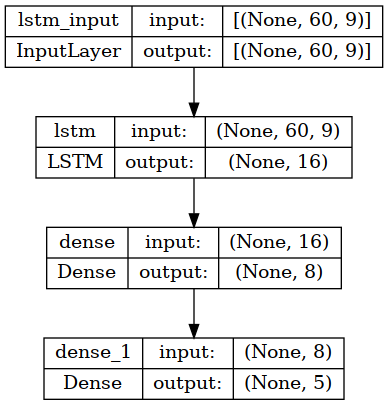

In [28]:
from keras.utils import plot_model
plot_model(model,show_shapes= True, show_layer_names= True, to_file='/home/RUS_CIP/st179677/project/LSTM.png')

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath_1 = '/home/RUS_CIP/st179677/project/model/models/LSTM/lstm_best_model.h5'


logdir = os.path.join("logs", datetime.datetime.now().strftime("softmax_%Y_%m_%d-%H_%M_%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

checkpoint = ModelCheckpoint(filepath=filepath_1, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

callbacks_list = [checkpoint, tensorboard_callback, early_stopping] # tf.keras.callbacks.TensorBoard(logdir), hp.KerasCallback(logdir, hparams)]

In [30]:
#LSTM model
from keras.optimizers import Adam

adam = Adam(learning_rate=0.0001)
# chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(X_train, y_train ,validation_data=([X_val], y_val), epochs=200, callbacks=callbacks_list, batch_size=32)

Epoch 1/200


2024-05-24 12:01:58.091941: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-24 12:01:58.091967: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-24 12:01:58.092019: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-24 12:01:58.092045: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

  35/1141 [..............................] - ETA: 3s - loss: 1.5920 - accuracy: 0.2214 

2024-05-24 12:01:58.982175: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-24 12:01:58.985581: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-24 12:01:58.985642: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-24 12:01:59.002852: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

1129/1141 [============================>.] - ETA: 0s - loss: 1.2383 - accuracy: 0.5394
Epoch 1: val_accuracy improved from -inf to 0.74088, saving model to /home/RUS_CIP/st179677/project/model/models/LSTM/lstm_best_model.h5
1141/1141 [==============================] - 5s 3ms/step - loss: 1.2350 - accuracy: 0.5413 - val_loss: 0.8853 - val_accuracy: 0.7409
Epoch 2/200
  36/1141 [..............................] - ETA: 3s - loss: 0.9041 - accuracy: 0.7378

/home/RUS_CIP/st179677/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1128/1141 [============================>.] - ETA: 0s - loss: 0.6978 - accuracy: 0.7793
Epoch 2: val_accuracy improved from 0.74088 to 0.81139, saving model to /home/RUS_CIP/st179677/project/model/models/LSTM/lstm_best_model.h5
1141/1141 [==============================] - 3s 3ms/step - loss: 0.6960 - accuracy: 0.7800 - val_loss: 0.5670 - val_accuracy: 0.8114
Epoch 3/200
1139/1141 [============================>.] - ETA: 0s - loss: 0.4746 - accuracy: 0.8542
Epoch 3: val_accuracy improved from 0.81139 to 0.88930, saving model to /home/RUS_CIP/st179677/project/model/models/LSTM/lstm_best_model.h5
1141/1141 [==============================] - 3s 3ms/step - loss: 0.4744 - accuracy: 0.8543 - val_loss: 0.4091 - val_accuracy: 0.8893
Epoch 4/200
1137/1141 [============================>.] - ETA: 0s - loss: 0.3693 - accuracy: 0.8973
Epoch 4: val_accuracy improved from 0.88930 to 0.90409, saving model to /home/RUS_CIP/st179677/project/model/models/LSTM/lstm_best_model.h5
1141/1141 [==================

In [31]:
# # Load the TensorBoard notebook extension
%load_ext tensorboard

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


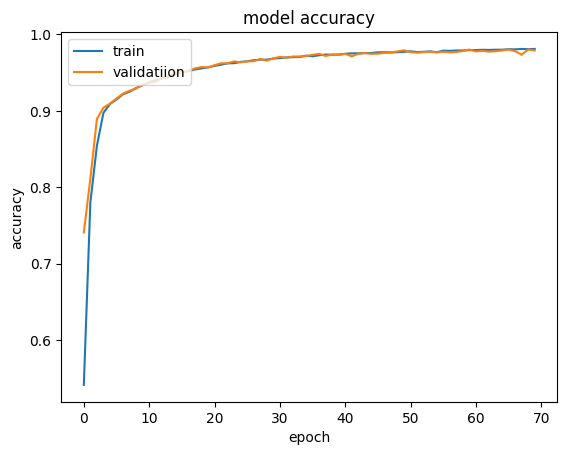

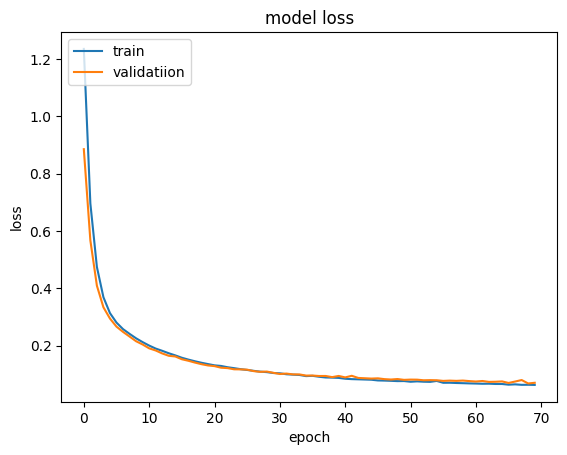

In [42]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validatiion'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validatiion'], loc='upper left')
plt.show()

In [33]:
#predicting on test datset
from keras.models import load_model
from sklearn.metrics import accuracy_score

# model = load_model(model_filepath)
print(type(X_test)) #reshape[1,:,:]
# print(X_test.shape)
classify_x=model.predict(X_test) 
# print(classify_x)
classes_x=np.argmax(classify_x,axis=1)
y_test= np.argmax(y_test,axis=1)
print(classes_x)
accuracy=accuracy_score(y_test, classes_x)
accuracy

<class 'numpy.ndarray'>
317/317 [==============================] - 0s 1ms/step
[0 2 0 ... 0 0 4]


0.9771158019333201

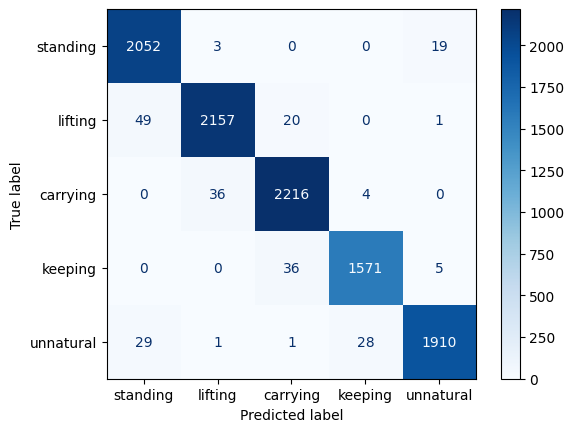

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2074
           1       0.98      0.97      0.98      2227
           2       0.97      0.98      0.98      2256
           3       0.98      0.97      0.98      1612
           4       0.99      0.97      0.98      1969

    accuracy                           0.98     10138
   macro avg       0.98      0.98      0.98     10138
weighted avg       0.98      0.98      0.98     10138



In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

labels = ["standing", "lifting", "carrying", "keeping", "unnatural"]

cm = confusion_matrix(y_test, classes_x)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(y_test, classes_x))

In [35]:
# model_name = f"{round(accuracy*100,2)}_lstm-2lay_60_shuffle_.h5"
# model_filepath=f'/home/RUS_CIP/st179677/project/model/{model_name}'

# model.save(model_filepath)

In [36]:
# test2 = pd.read_csv('/home/RUS_CIP/st179677/project/dataset/standing_values_100_FPS.csv')
# test2


In [37]:
# labels2 = test2['labels']

In [38]:
# features2 = ["NeckFlEx", "HeadSideTilt", "NeckTors", "AngleElbowLeft", "ElbowRight", "AngleLegLeft", "LegRight","AngleShoulderAbAdLeft", "ShoulderAbAdRight", "AngleTorsoTilt", "AngleTorsoSideTilt"]

In [39]:
# test2 = test2[features2]
# test2

In [40]:
# ss = StandardScaler()
# test2 = pd.DataFrame(ss.fit_transform(test2),columns = test2.columns, index=test2.index)

# test2


In [41]:
# # Create 51 empty lists with names X0 to X50
# X0, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, y = ([] for _ in range(12))